In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from scipy.stats import median_abs_deviation as mad
import scvi

sc.settings.n_jobs = 8
sc.set_figure_params(dpi=100, dpi_save=600, frameon=False, figsize=(5,5))
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"
%config InlineBackend.figure_format = 'retina'

In [2]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/", R: "/Users/pax/RNAse4/Notebook"
  warnings.warn(
/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "DYLD_FALLBACK_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/Users/pax/miniconda3/envs/rnase4/lib/R/lib:/Users/pax/miniconda3/envs/rnase4/lib:/Users/runner/miniforge3/conda-bld/r-base-split_1747311881815/_build_env/lib/jvm/lib/server", R: "/Users/pax/miniconda3/envs/rnase4/lib/R/lib:/Users/pax/miniconda3/envs/rnase4/lib:/Users/runner/miniforge3/conda-bld/r-base-split_1747311881815/_build_env/lib/jvm/lib/server:/Users/pax/miniconda3/envs/rnase4/lib/R/lib:/Users/pax/miniconda3/envs/rnase4/lib:/Users/runner/miniforge3/conda-bld/r-base-split_1747311881815/_build_env/lib/jvm/lib/server"
  w

In [ ]:
# def mad_outlier(adata, metric, nmads):
#     M = adata.obs[metric]
#     return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    

def pp(sample_id, base_path='/Volumes/T5/Rnase4_10x/mtx/'):
    adata = sc.read_10x_mtx(base_path + sample_id + '/filtered_feature_bc_matrix')
    adata.obs['sample_id'] = sample_id
    
    
    #calculate QC metrics
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"],
                               inplace=True, percent_top=[20], log1p=True)
    
    
    #filter outliers
    adata = adata[(adata.obs.n_genes_by_counts < 6000) & (adata.obs.pct_counts_mt < 0.5)].copy()
    
    return adata

In [4]:
def get_soupx_group(adata):
    adata_pp = adata.copy()
    sc.pp.normalize_total(adata_pp)
    sc.pp.log1p(adata_pp)
    sc.pp.pca(adata_pp)
    sc.pp.neighbors(adata_pp)
    sc.tl.leiden(adata_pp, key_added="soupx_groups")
    return adata_pp.obs['soupx_groups']
    
    

def prepare_broth(adata, base_path='/Volumes/T5/Rnase4_10x/mtx/'):
    # Make into individual components to pass to R
    cells = adata.obs_names
    genes = adata.var_names
    data = adata.X.T
    
    #get raw data
    sample_id = adata.obs.iloc[0]['sample_id']
    raw = sc.read_10x_mtx(base_path + sample_id + '/raw_feature_bc_matrix/').X.T
    
    #get leiden clusters
    soupx_groups = get_soupx_group(adata)

    return data, raw, genes, cells, soupx_groups

In [5]:
%%R

library(SoupX)

make_soup <- function(data, raw, genes, cells, soupx_groups){
    # specify row and column names of data
    rownames(data) = genes
    colnames(data) = cells
    # ensure correct sparse format for table of counts and table of droplets
    data <- as(data, "sparseMatrix")
    raw <- as(raw, "sparseMatrix")

    # Generate SoupChannel Object for SoupX 
    sc = SoupChannel(raw, data, calcSoupProfile = FALSE)

    # Add extra meta data to the SoupChannel object
    soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
    sc = setSoupProfile(sc, soupProf)
    # Set cluster information in SoupChannel
    sc = setClusters(sc, soupx_groups)

    # Estimate contamination fraction
    sc  = autoEstCont(sc, doPlot=FALSE)
    # Infer corrected table of counts and round to integer
    out = adjustCounts(sc, roundToInt = TRUE)
    
    return(out)
}


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [6]:
def cook_soup(adata):
    data, raw, genes, cells, soupx_groups = prepare_broth(adata)

    # Execute the R code and get the corrected counts
    %R -i data --converter anndata2ri.converter -i raw -i genes -i cells -i soupx_groups -o out out = make_soup(data, raw, genes, cells, soupx_groups)


    adata.layers["raw_counts"] = adata.X.copy()
    adata.layers["soupX_counts"] = out.T.copy()
    adata.X = adata.layers["soupX_counts"]
    
    return adata

In [7]:
sample_ids = ['P36003_101','P36003_102']
adatas = [pp(adata) for adata in tqdm(sample_ids, total=len(sample_ids))]
adatas = [cook_soup(adata) for adata in adatas]

100%|██████████| 2/2 [00:03<00:00,  1.73s/it]
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_40044/2942199146.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_pp, key_added="soupx_groups")


2488 genes passed tf-idf cut-off and 1392 soup quantile filter.  Taking the top 100.
Using 1215 independent estimates of rho.
Estimated global rho of 0.04
Expanding counts from 19 clusters to 4320 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


3113 genes passed tf-idf cut-off and 1564 soup quantile filter.  Taking the top 100.
Using 1071 independent estimates of rho.
Estimated global rho of 0.05
Expanding counts from 23 clusters to 10908 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you


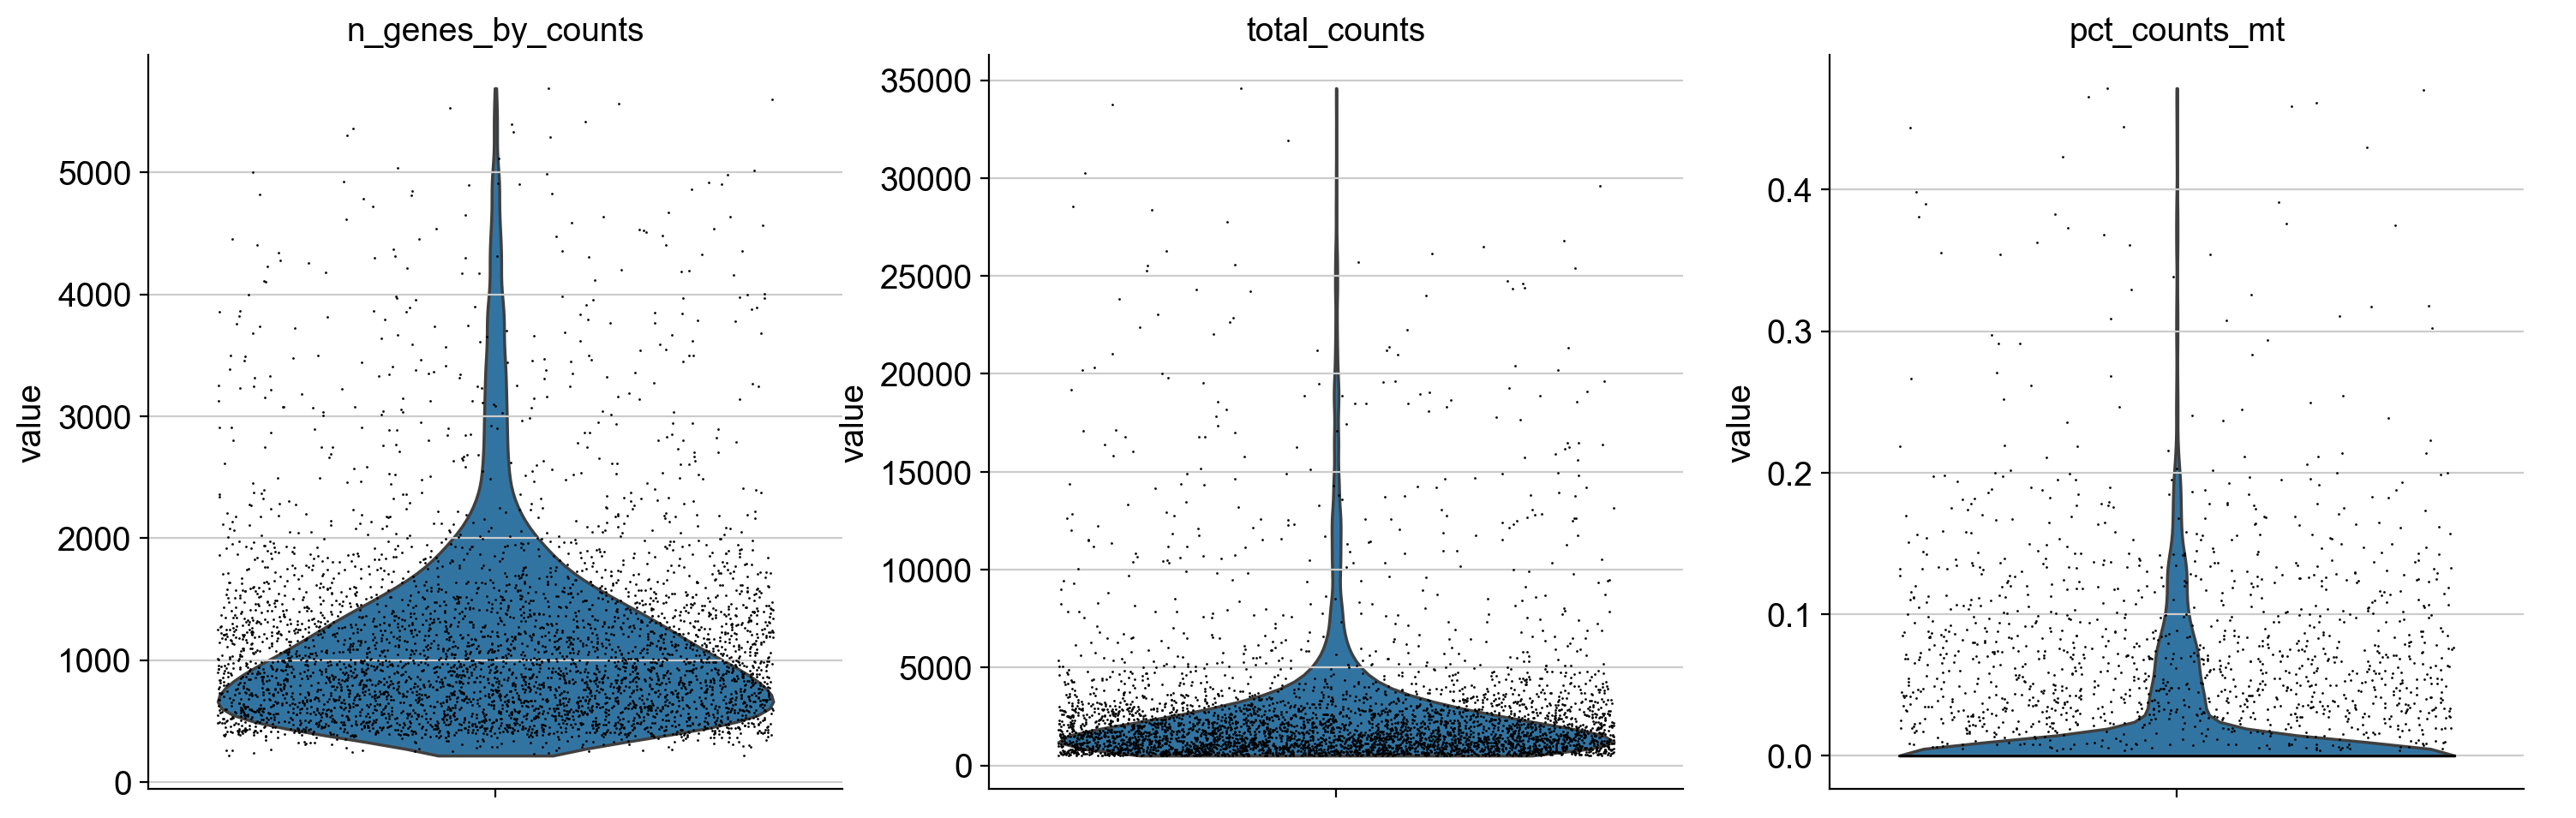

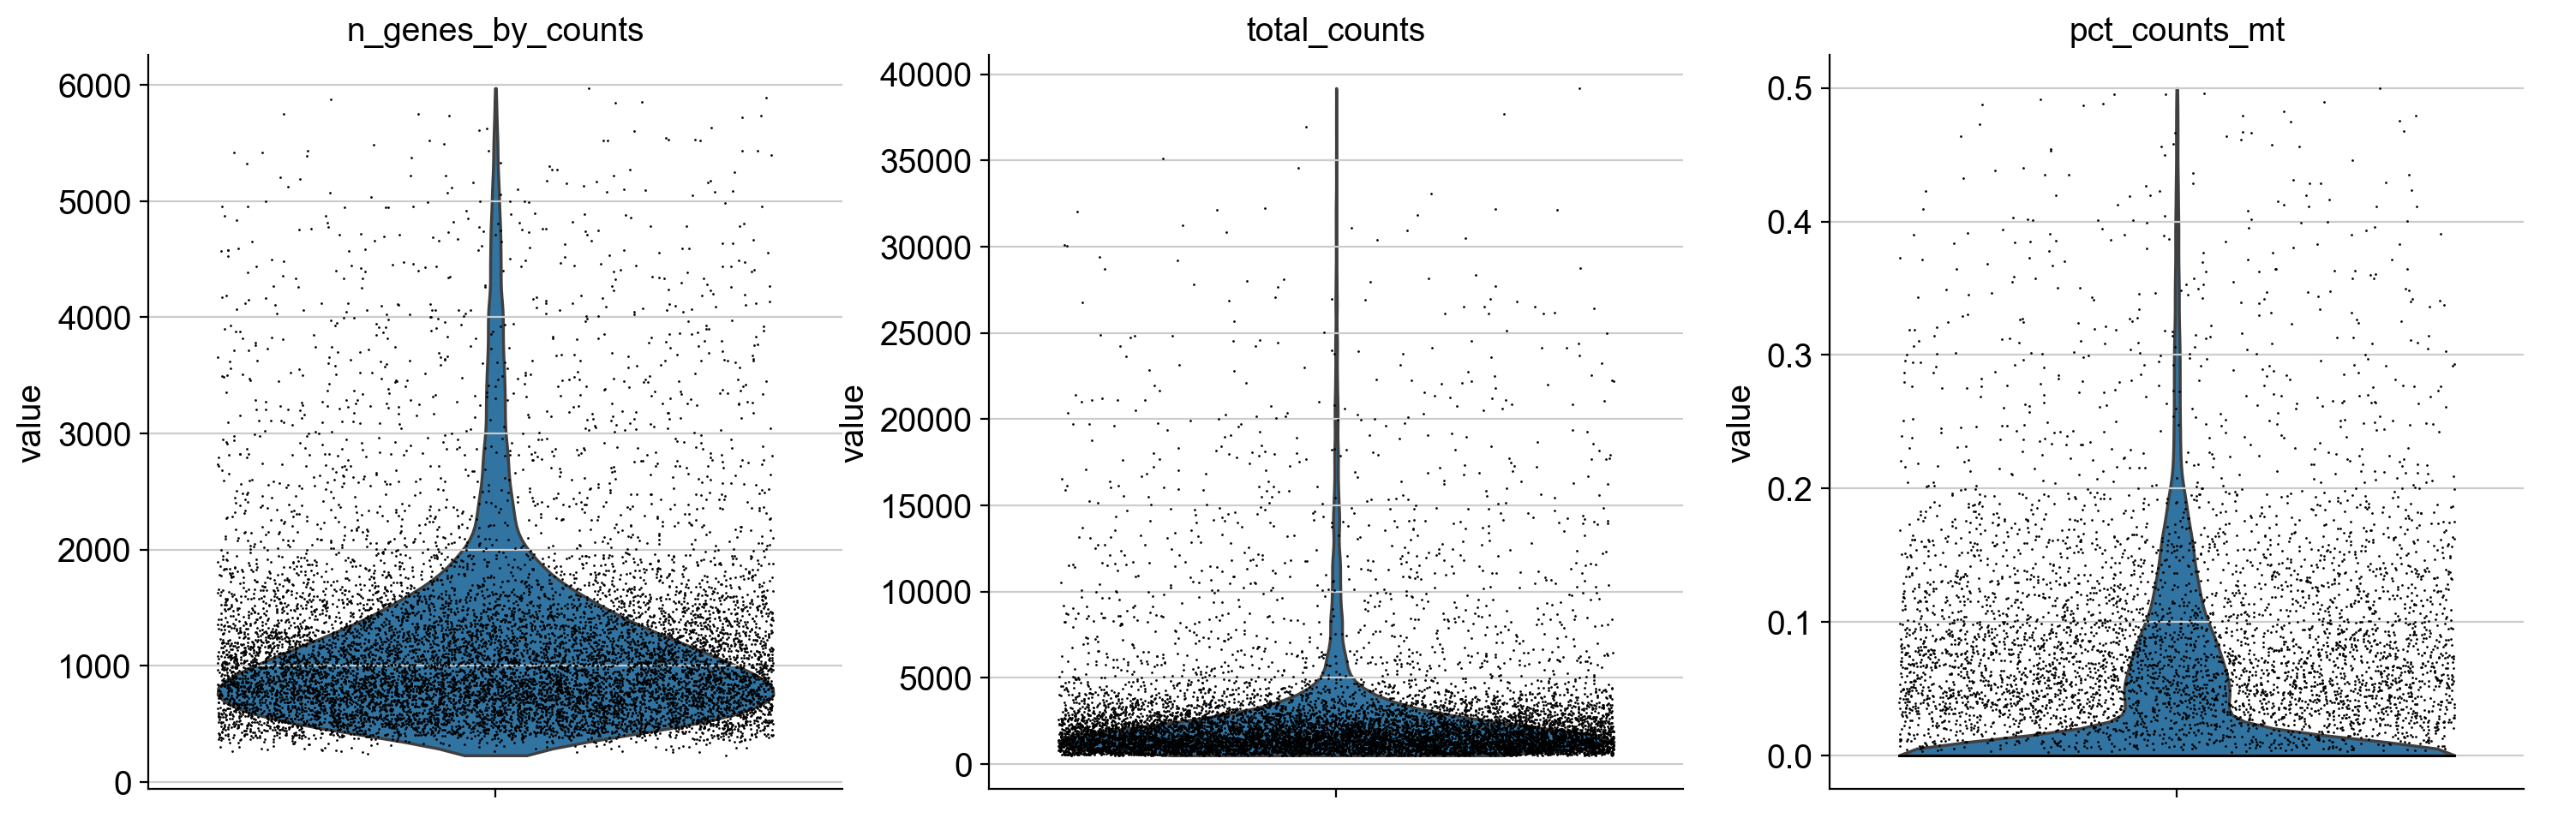

In [8]:
sc.pl.violin(adatas[0], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)
sc.pl.violin(adatas[1], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

In [13]:
adatas[0].layers['soupX_counts'].sum()/adatas[0].layers['raw_counts'].sum()

np.float64(0.9650248426231561)

In [15]:
adatas[1].layers['soupX_counts'].sum()/adatas[1].layers['raw_counts'].sum()

np.float64(0.948024179850733)

In [ ]:
adata = sc.concat(adatas, label='Conditions', keys=['WT','cKO-PR'])
adata.obs_names = adata.obs_names + '_' + adata.obs.Conditions.astype(str)
sc.pp.filter_genes(adata, min_cells=3)

/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [27]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

In [28]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3', layer='soupX_counts')

In [29]:
adata.obsm['X_pca'] = sc.pp.pca(sc.pp.scale(adata[:, adata.var.highly_variable].X))

In [31]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata, min_dist=0.3)

In [71]:
adata.obs.Conditions = adata.obs.Conditions.apply(lambda x: 'cKO-PR' if x == 'cKO-BR' else x)

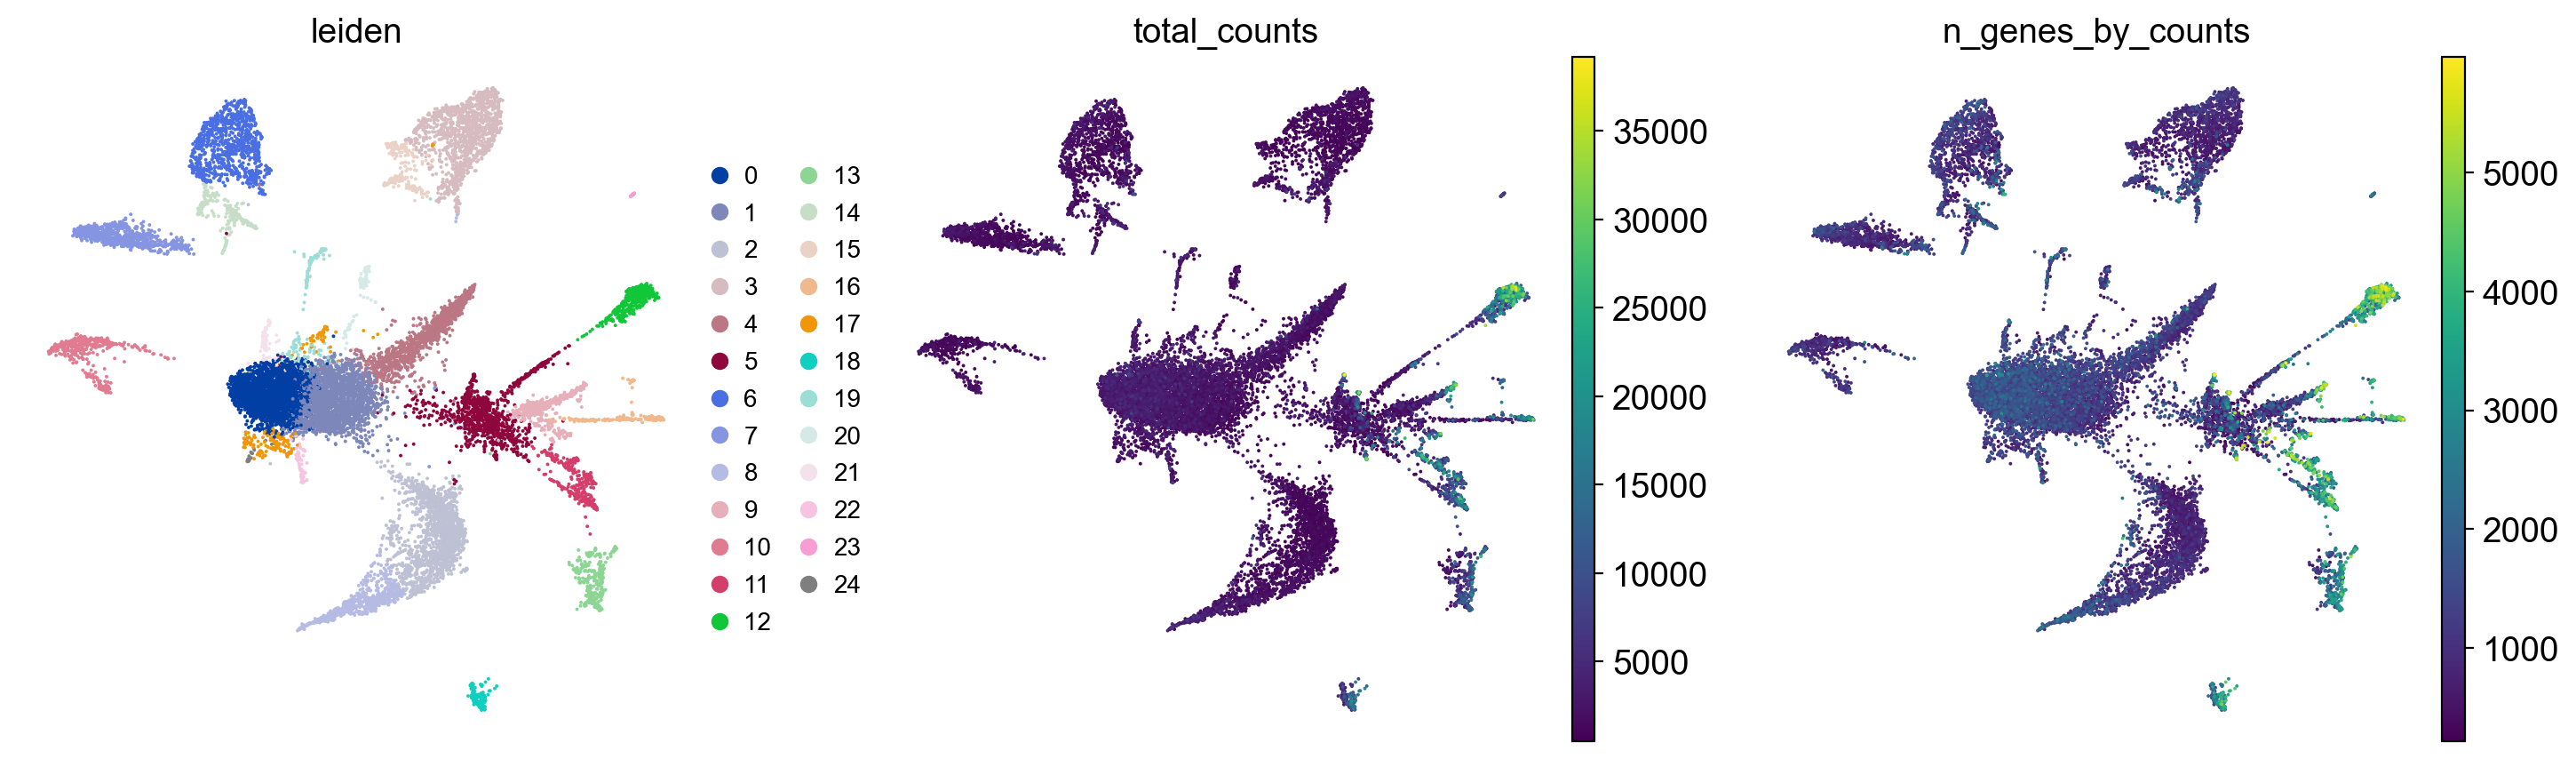

In [72]:
sc.pl.umap(adata, color=['leiden','total_counts','n_genes_by_counts'])

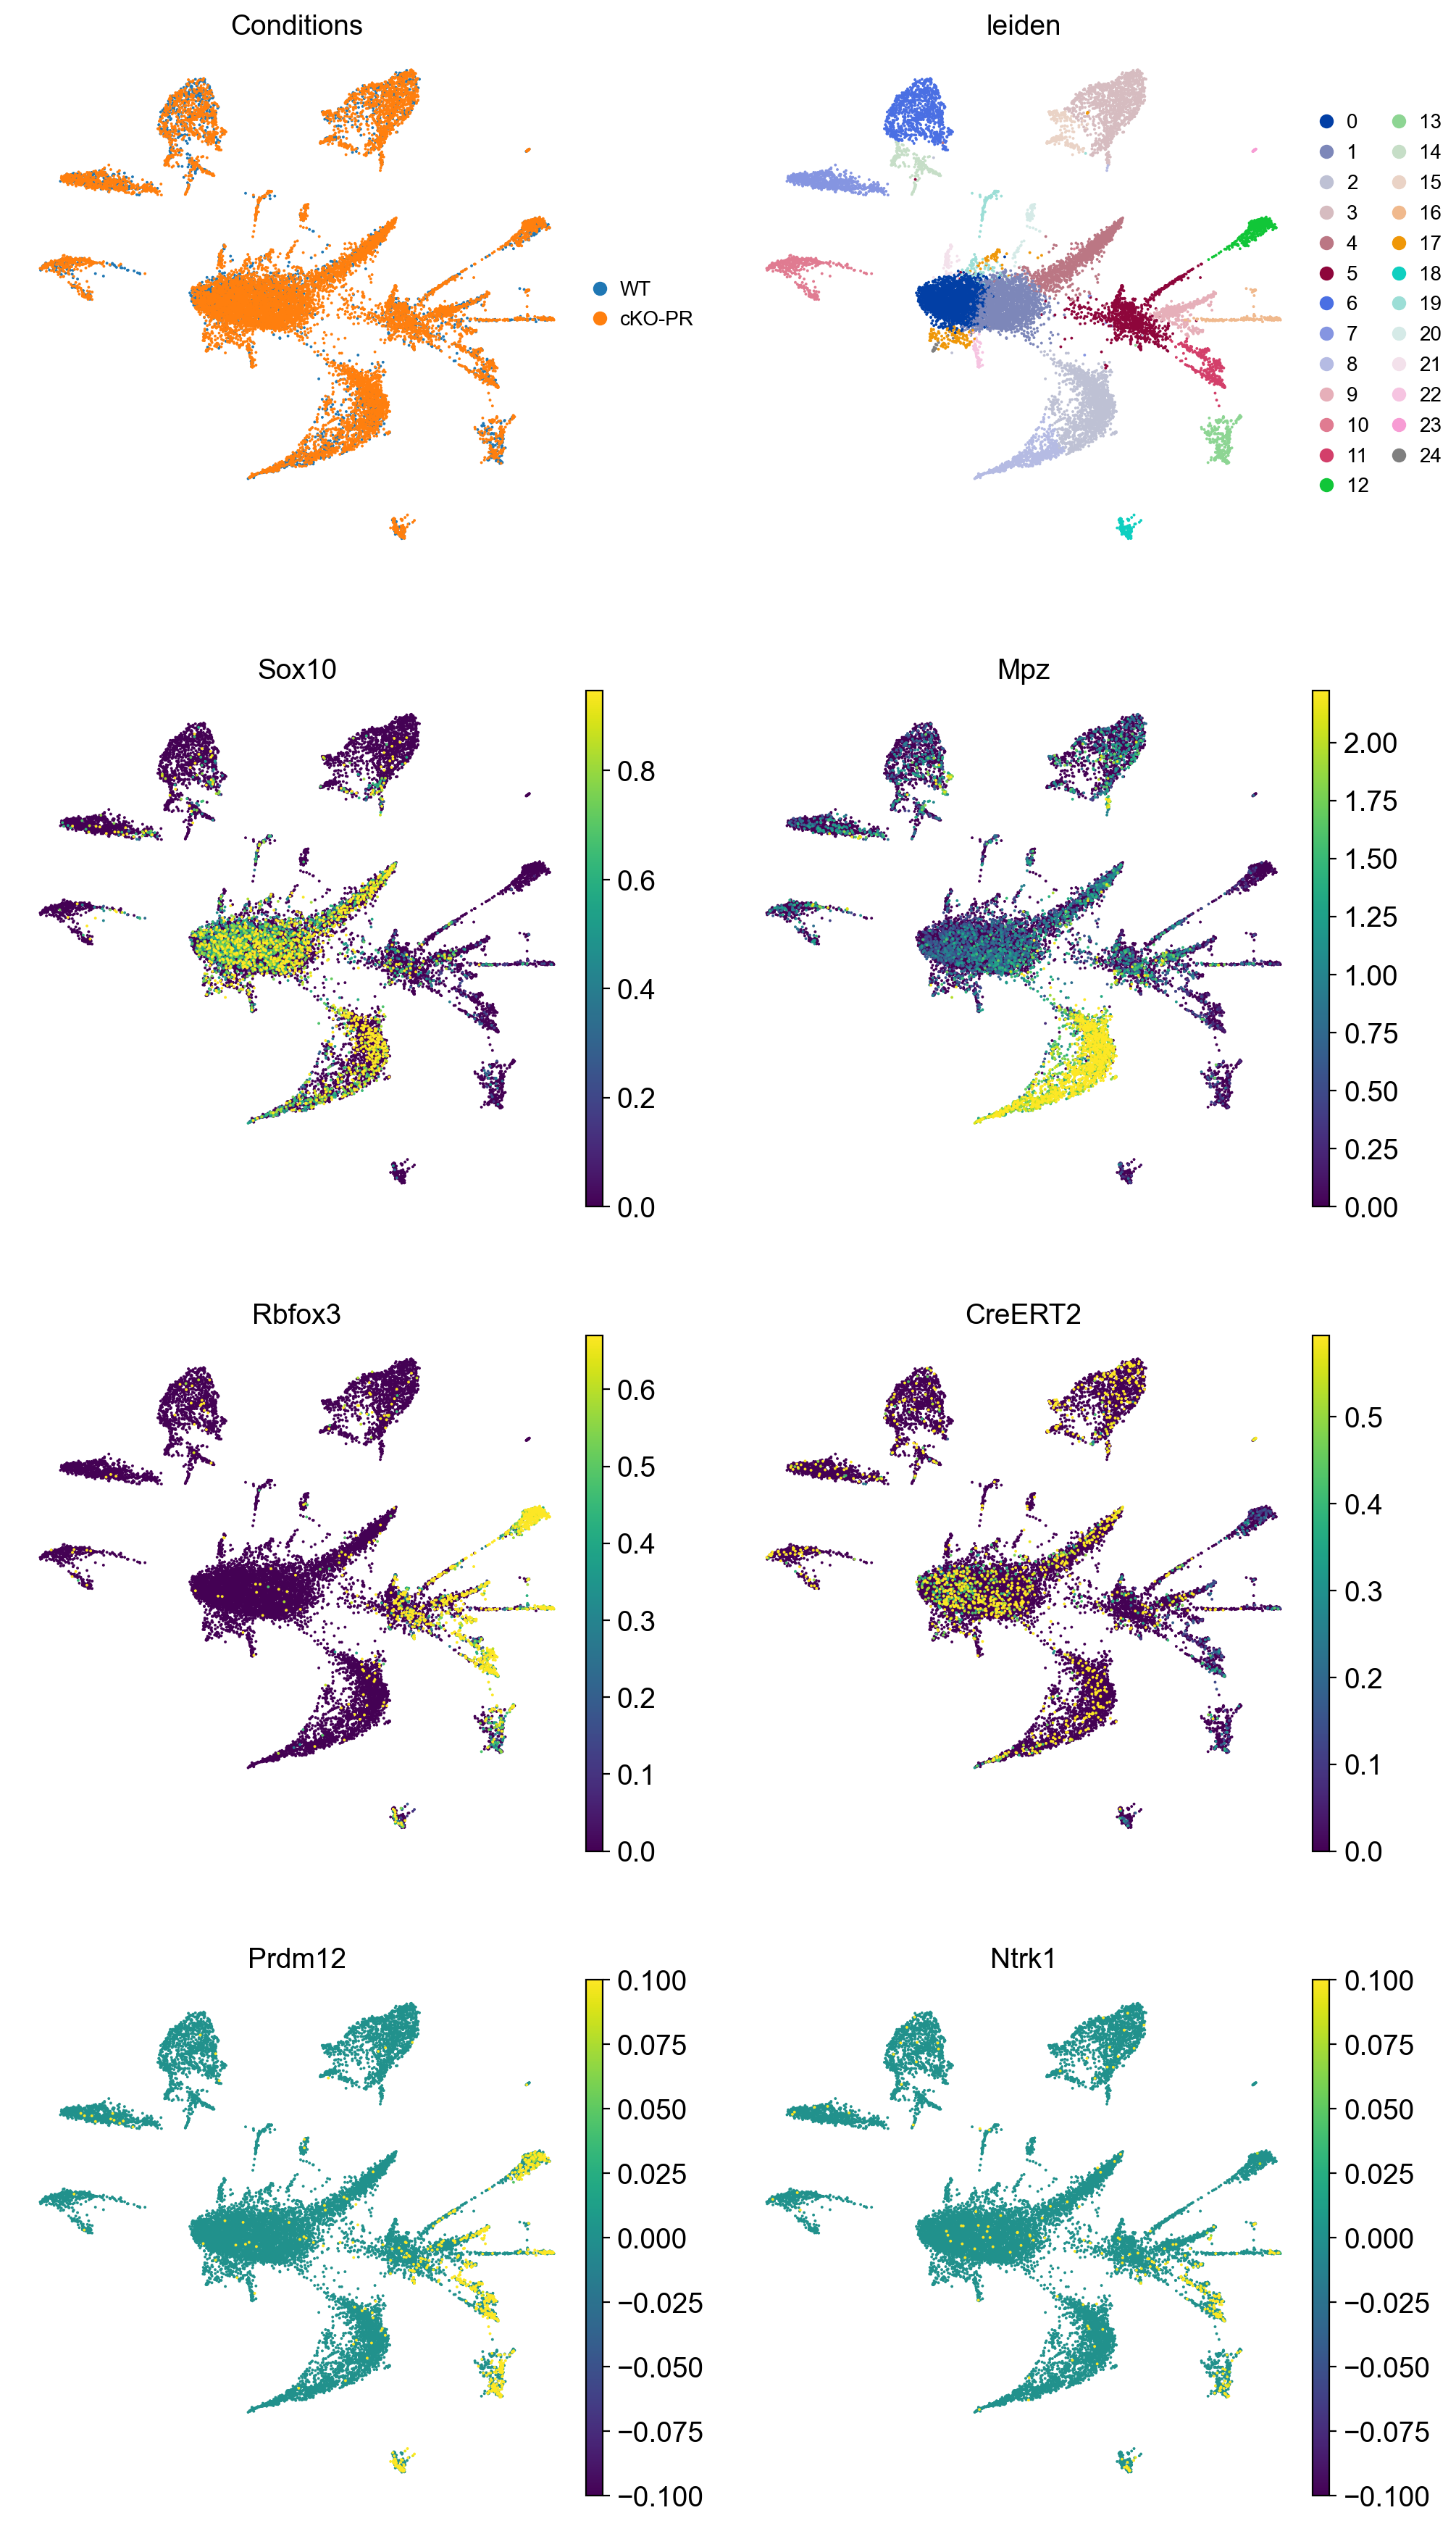

In [73]:
sc.pl.umap(adata, color=['Conditions','leiden','Sox10','Mpz','Rbfox3','CreERT2','Prdm12','Ntrk1'], ncols=2, vmax='p95')

In [ ]:
adata.write_h5ad('/Volumes/T5/Rnase4_10x/rnase4_adata_prepro.h5ad', compression='gzip')

In [ ]:
adata = sc.read_h5ad('/Volumes/T5/Rnase4_10x/rnase4_adata_prepro.h5ad')

In [7]:
import sys
import pandas
sys.modules['pandas.core.indexes.numeric'] = pandas.core.indexes.base
pandas.core.indexes.base.Int64Index = pandas.core.indexes.base.Index

In [ ]:
adata_scanvi = sc.read_h5ad('./scanvi_model/adata.h5ad')
adata_scanvi.obsm['scanvi_latent_qzm'] = adata_scanvi.obsm['_scanvi_latent_qzm'].copy()
adata_scanvi.obsm['scanvi_latent_qzv'] = adata_scanvi.obsm['_scanvi_latent_qzv'].copy()
adata_scanvi.obs['observed_lib_size'] = adata_scanvi.obs['_scanvi_observed_lib_size'].copy()
lvae = scvi.model.SCANVI.load('./scanvi_model', adata=adata_scanvi)

In [ ]:
adata.obs['Source'] = 'Techamaana_10x'
adata.obs['celltype_scanvi'] = 'Unknown'
adata.layers['counts'] = adata.layers['raw_counts'].copy()

In [ ]:
adata_drg_scvi = adata.copy()
scvi.model.SCANVI.prepare_query_anndata(adata_drg_scvi, reference_model=lvae)
lvae_q = scvi.model.SCANVI.load_query_data(adata_drg_scvi,lvae)

INFO     Found 85.07164278573809% reference vars in query data.                                                    


/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/scvi/model/base/_archesmixin.py:105: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, device = parse_device_args(


In [24]:
lvae_q.train(n_samples_per_label=30, accelerator='mps')

INFO     Training for 400 epochs.                                                                                  


/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [ ]:
lvae_q.save('scanvi_query_10', save_anndata=True, compression='gzip', overwrite=True)

... storing 'Source' as categorical
... storing 'celltype_scanvi' as categorical


In [25]:
adata.obs['scANVI_pred'] = lvae_q.predict()

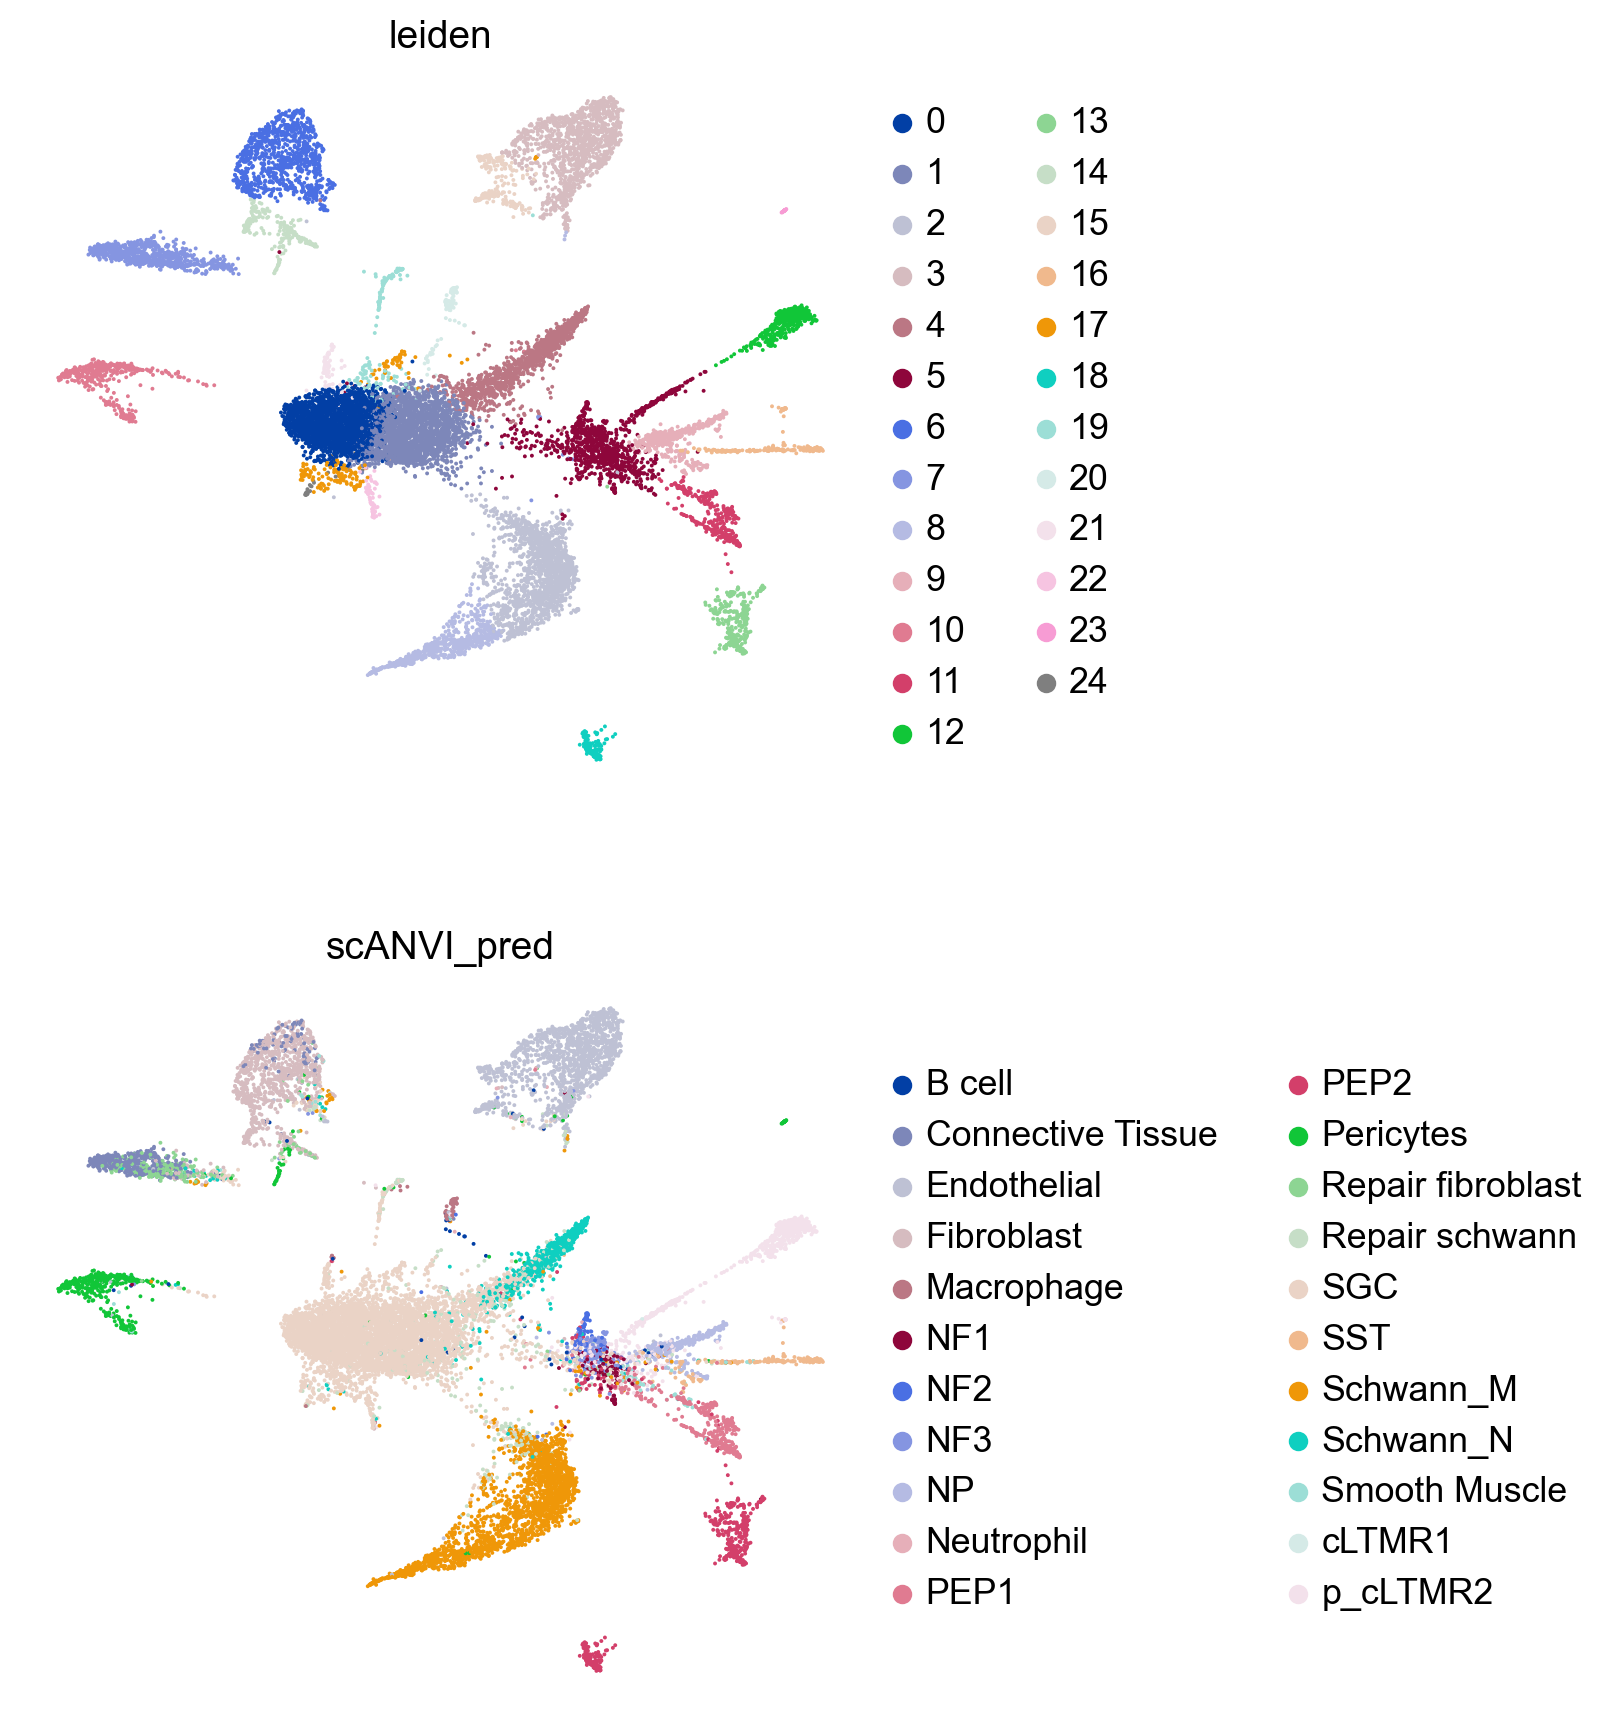

In [ ]:
sc.pl.umap(adata, color=['leiden','scANVI_pred'], ncols=1)

In [43]:
cluster_mapper = adata.obs.groupby('leiden').scANVI_pred.agg(pd.Series.mode).to_dict()

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_66216/969314962.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_mapper = adata.obs.groupby('leiden').scANVI_pred.agg(pd.Series.mode).to_dict()


In [ ]:
adata.obs['ct_cleaned'] = adata.obs.leiden.apply(lambda x: cluster_mapper.get(x) if x != '5' else x)
adata.obs.loc[adata.obs.ct_cleaned == '5', 'ct_cleaned'] = adata.obs.loc[adata.obs.ct_cleaned == '5', 'scANVI_pred']

In [52]:
adata.obs['MetaType'] = adata.obs.ct_cleaned.tolist()
adata.obs.MetaType = adata.obs.MetaType.apply(lambda x: 'NFs' if x.startswith('NF') else x)
adata.obs.MetaType = adata.obs.MetaType.apply(lambda x: 'Nociceptors' if x in ['NP','PEP1','PEP2','SST','cLTMR1','p_cLTMR2'] else x)

In [53]:
del adata.uns['MetaType_colors']

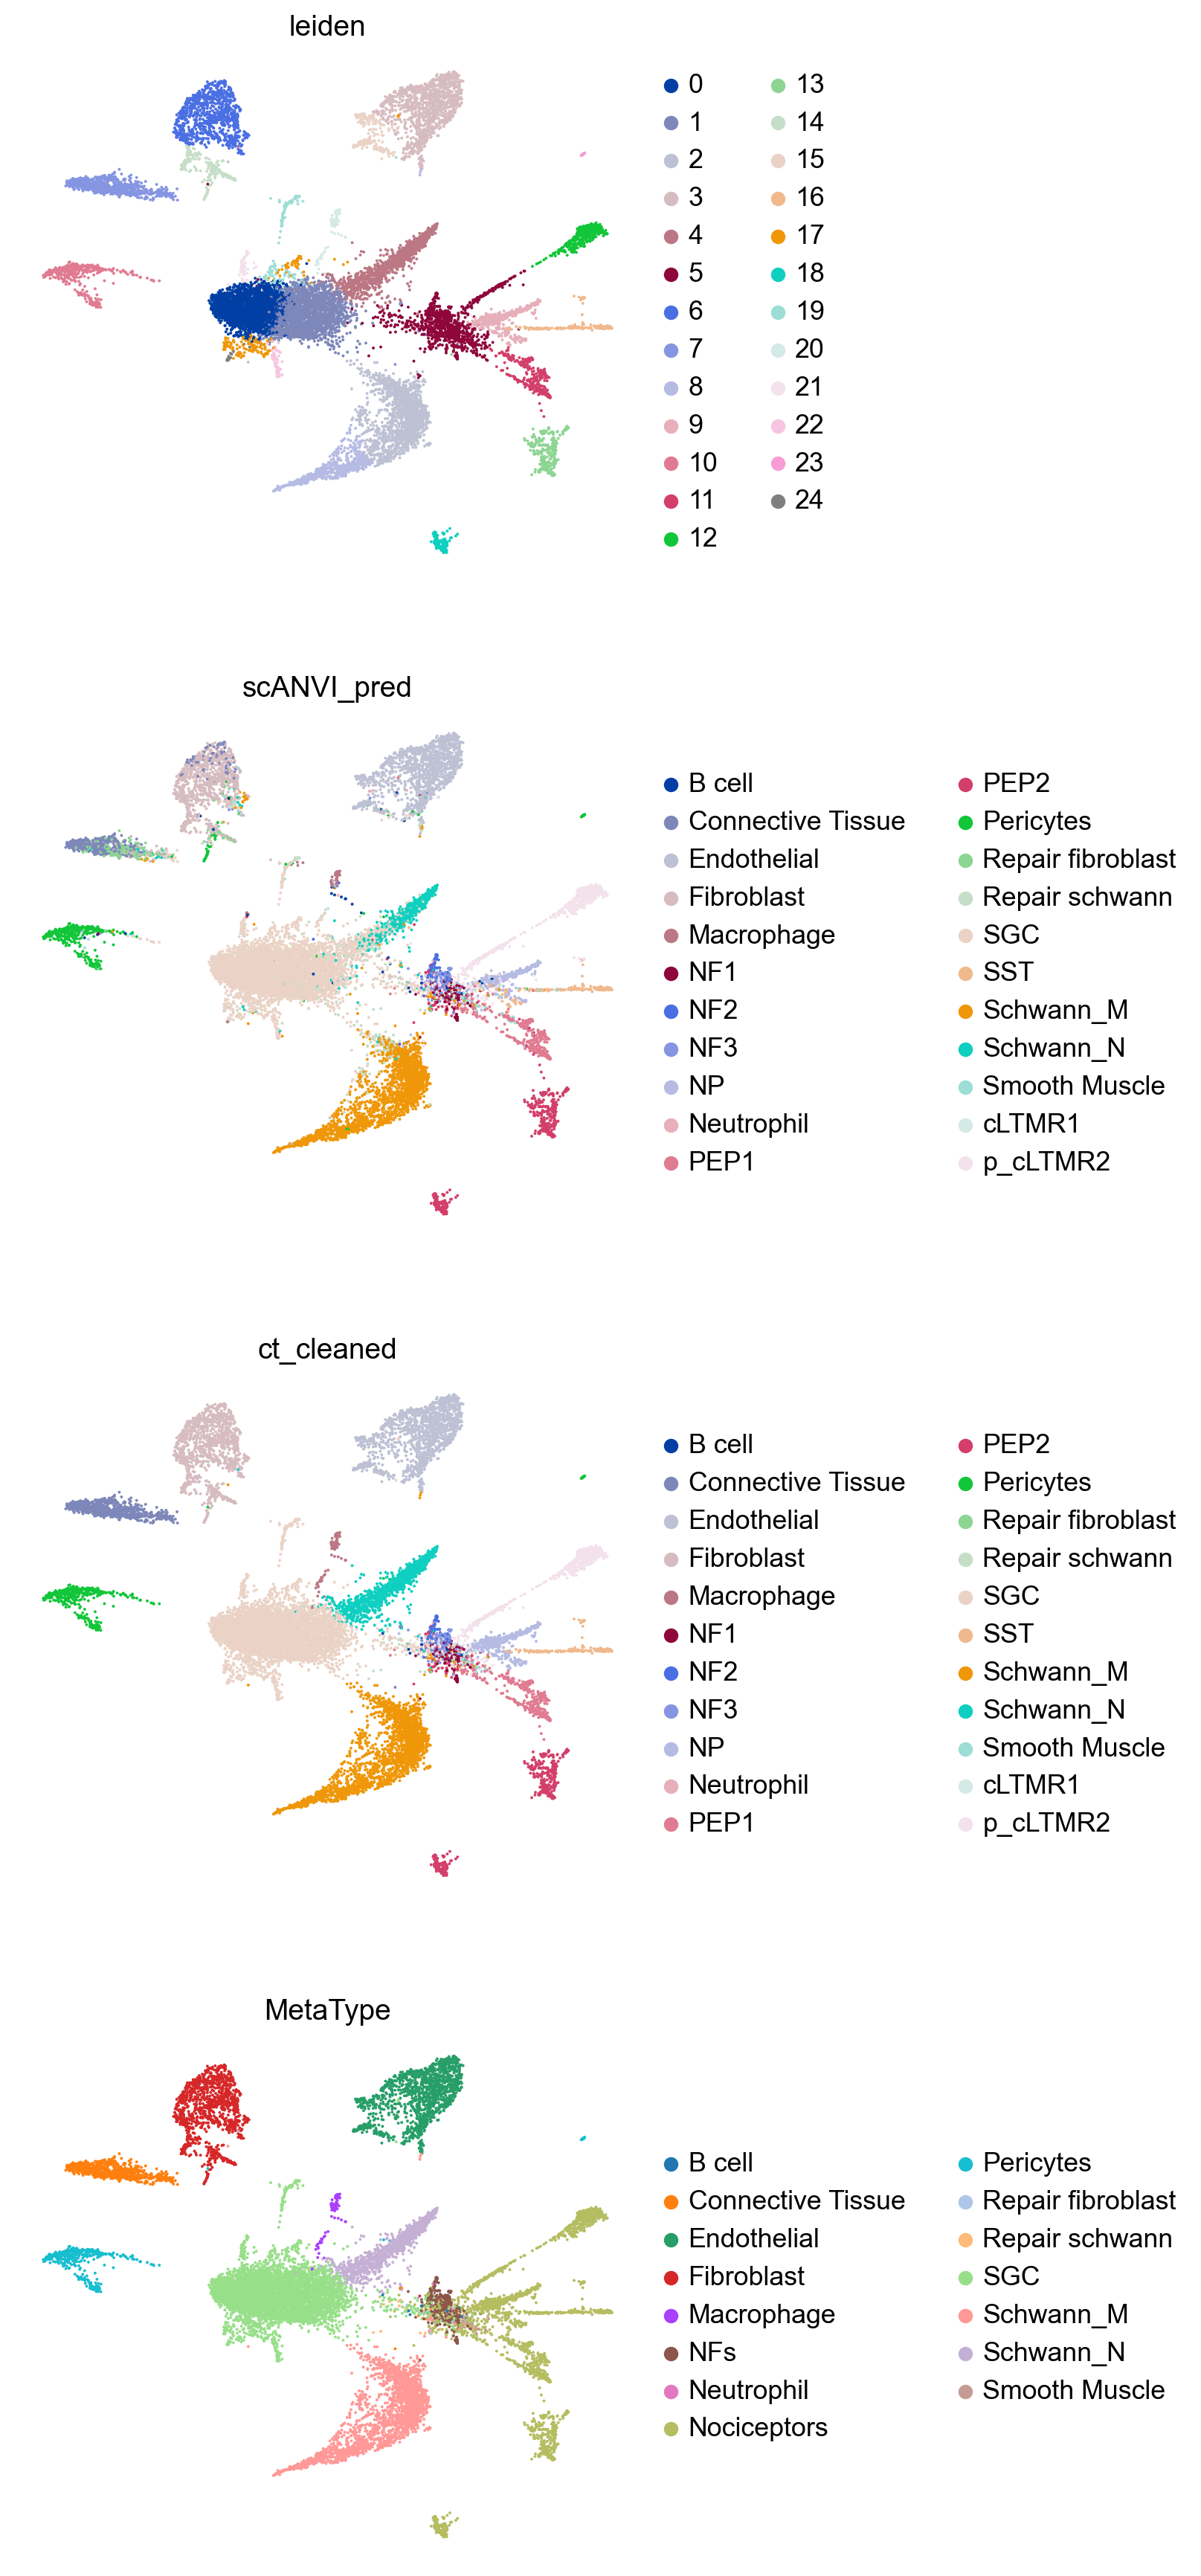

In [55]:
sc.pl.umap(adata, color=['leiden','scANVI_pred','ct_cleaned','MetaType'], ncols=1)

In [75]:
adata.obs['ct_conditions'] = adata.obs.MetaType.astype(str) + '_' + adata.obs.Conditions.astype(str)

In [205]:
adata.write_h5ad('/Volumes/T5/Rnase4_10x/rnase4_adata_analyzed.h5ad', compression='gzip')

... storing 'ct_conditions' as categorical


In [ ]:
sc.tl.rank_genes_groups(adata, groupby='ct_conditions', groups=['Nociceptors_cKO-PR'], pts=True,
                        reference='Nociceptors_WT', key_added='Nociceptors', method='t-test_overestim_var')

In [66]:
deg_df = sc.get.rank_genes_groups_df(adata, group=None, key='Nociceptors')

In [2]:
adata = sc.read_h5ad('/Volumes/T5/Rnase4_10x/rnase4_adata_analyzed.h5ad')

# Nociceptors

In [ ]:
adata_noci = adata[adata.obs.MetaType == 'Nociceptors'].copy()
sc.pp.neighbors(adata_noci)
# sc.tl.leiden(adata_noci)
sc.tl.umap(adata_noci, min_dist=0.3)

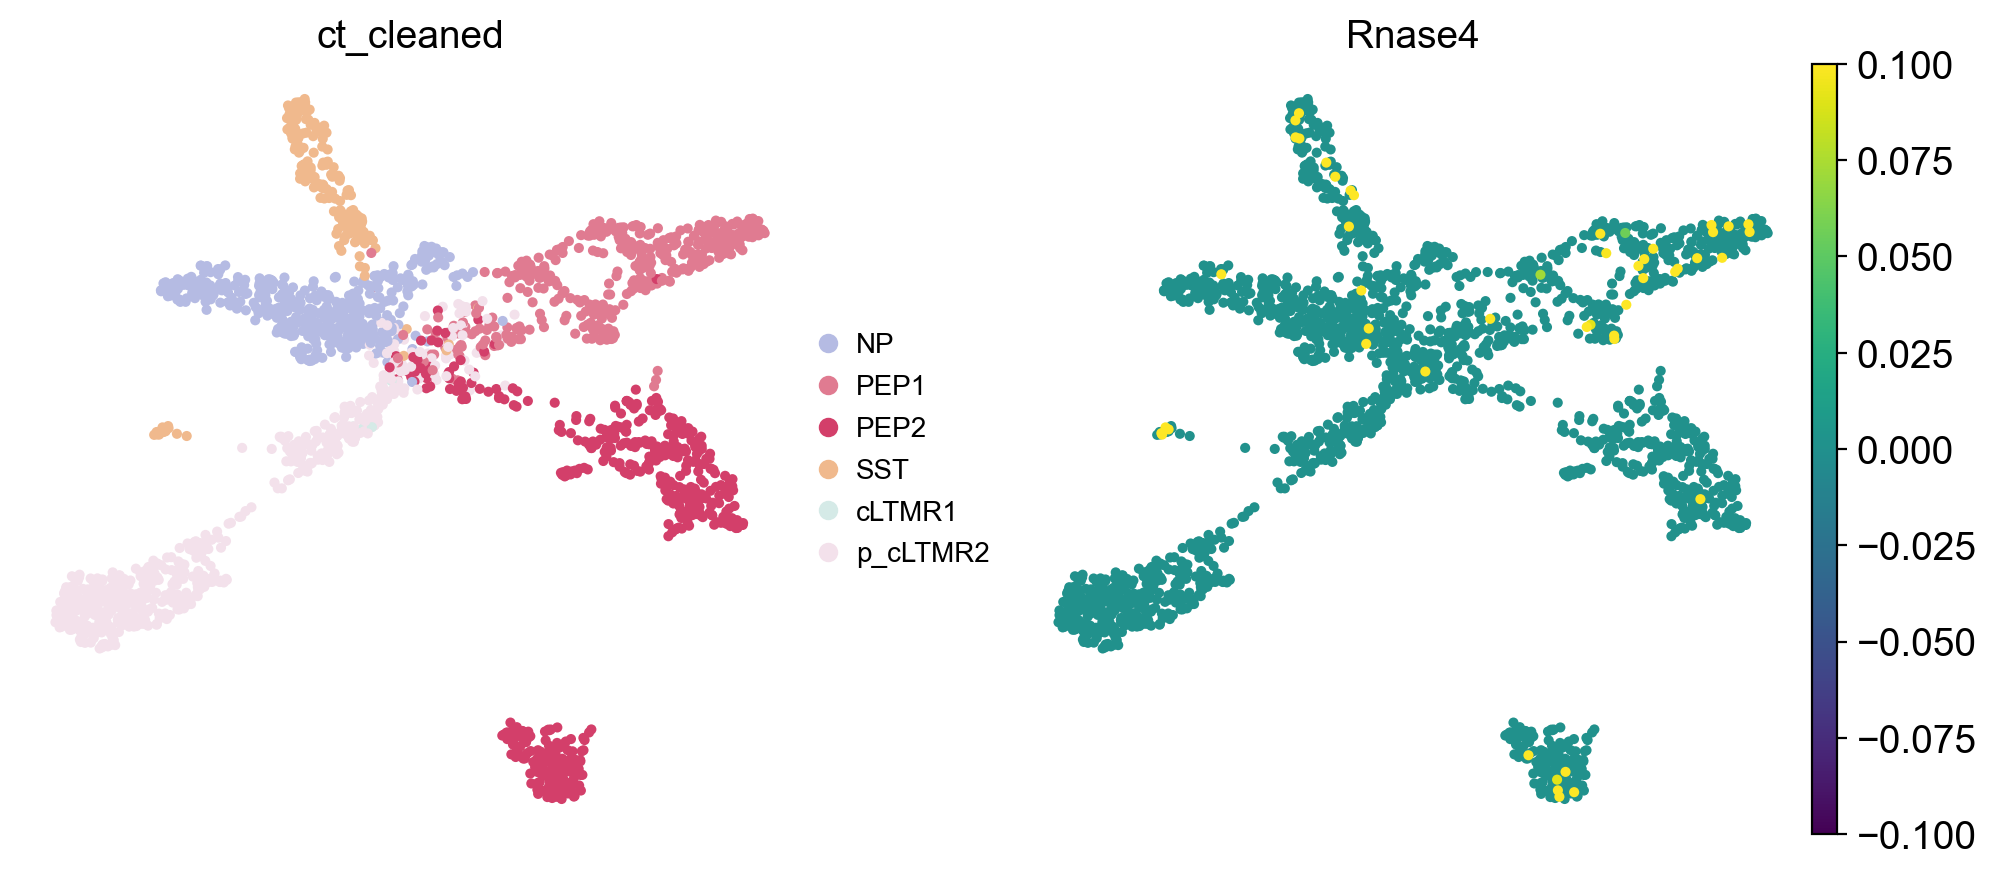

In [220]:
sc.pl.umap(adata_noci, color=['ct_cleaned','Rnase4'], vmax='p95')

In [88]:
adata_noci.obs['Rnase4_binary'] = (adata_noci[:,'Rnase4'].X.toarray().squeeze().copy() > 0).astype(str)

/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/scanpy/plotting/_utils.py:481: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


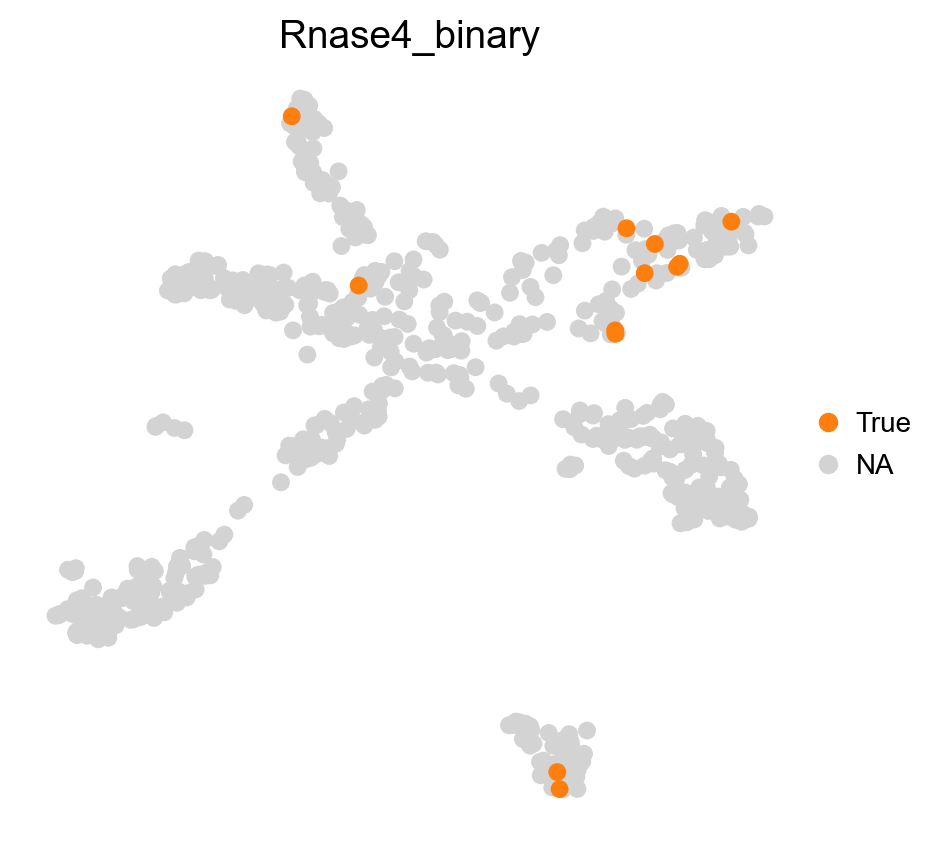

/Users/pax/miniconda3/envs/rnase4/lib/python3.11/site-packages/scanpy/plotting/_utils.py:481: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


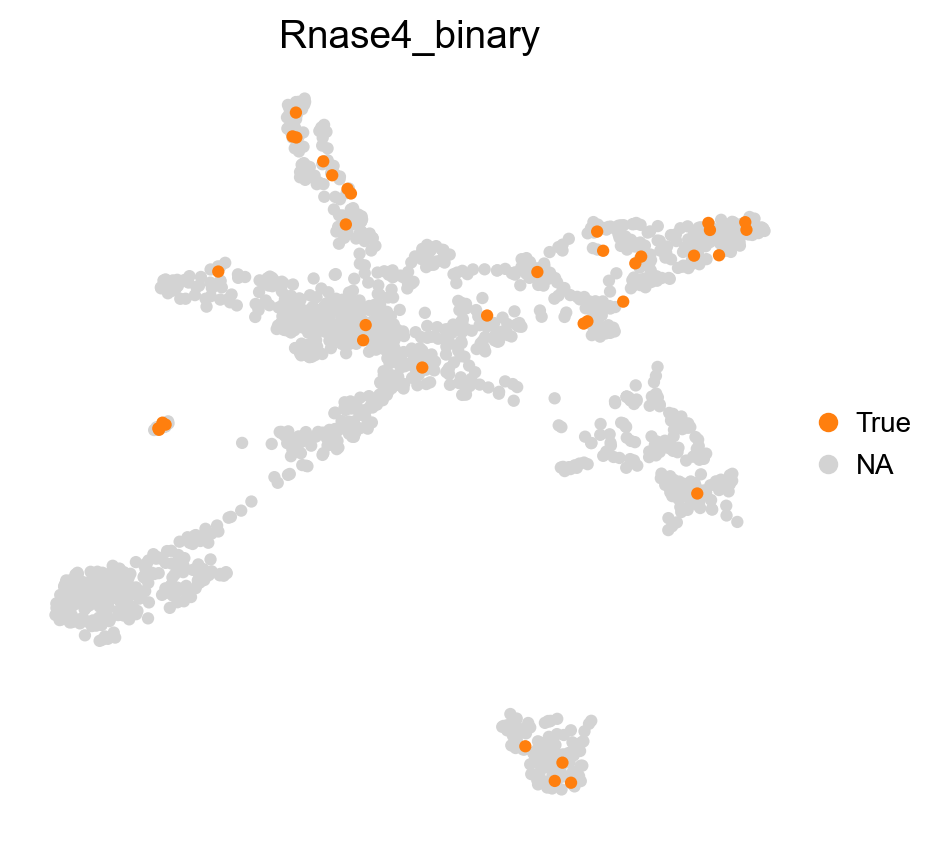

In [207]:
sc.pl.umap(adata_noci[adata_noci.obs.Conditions == 'WT'], color='Rnase4_binary', cmap='Reds', groups='True')
sc.pl.umap(adata_noci[adata_noci.obs.Conditions != 'WT'], color='Rnase4_binary', cmap='Reds', groups='True')

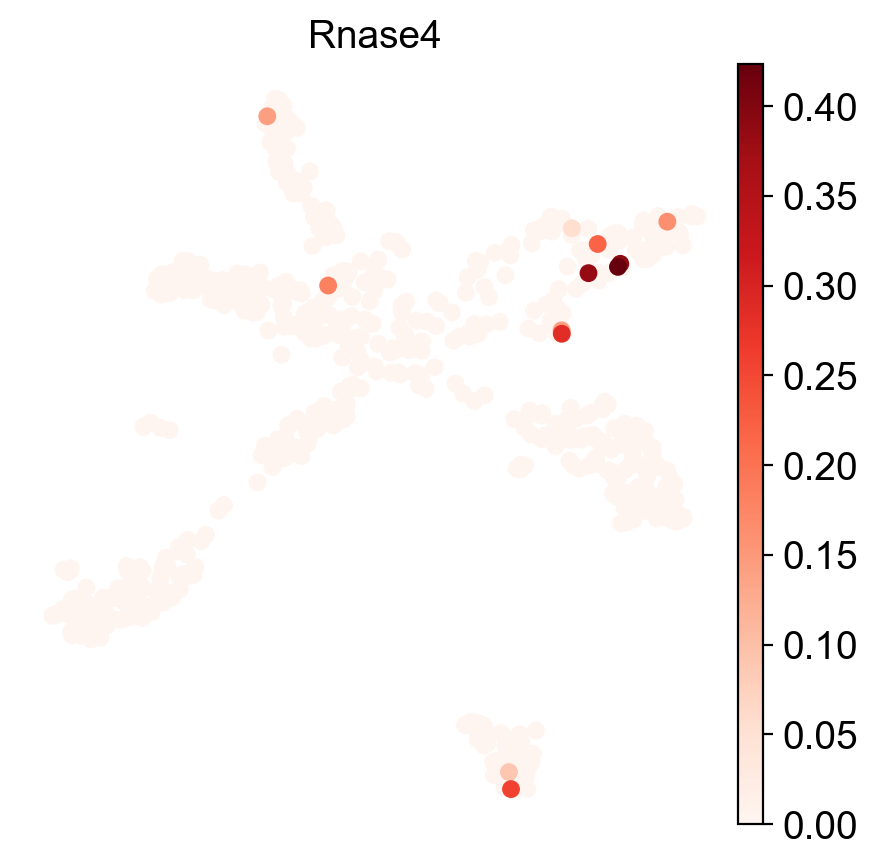

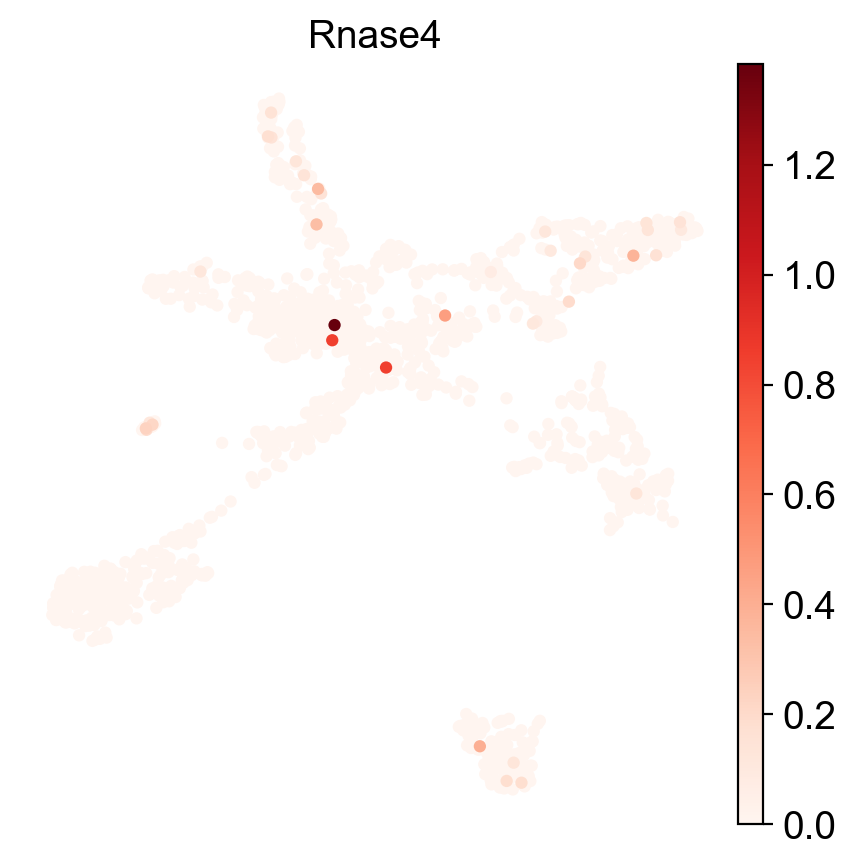

In [208]:
sc.pl.umap(adata_noci[adata_noci.obs.Conditions == 'WT'], color='Rnase4', cmap='Reds')
sc.pl.umap(adata_noci[adata_noci.obs.Conditions != 'WT'], color='Rnase4', cmap='Reds')

In [97]:
sc.tl.rank_genes_groups(adata_noci, groupby='ct_conditions', groups=['Nociceptors_cKO-PR'], pts=True,
                        reference='Nociceptors_WT', key_added='Nociceptors', method='t-test_overestim_var')
deg_df = sc.get.rank_genes_groups_df(adata_noci, group=None, key='Nociceptors')

In [103]:
sc.tl.rank_genes_groups(adata_noci, groupby='ct_conditions', pts=True, key_added='Nociceptors', method='t-test_overestim_var')
deg_df = sc.get.rank_genes_groups_df(adata_noci, group=None, key='Nociceptors')

In [ ]:
adata.obs['ct_conditions'] = adata.obs.MetaType.astype(str) + '_' + adata.obs.Conditions.astype(str)

In [121]:
def stack_vln(adata:sc.AnnData, markers:list, groupby:str, layer:str, figsize:tuple=(5,8), pad:float=-0.5, **kwds):
    fig, ax = plt.subplots(len(markers),1, figsize=figsize)
    for i,g in enumerate(markers):
        sc.pl.violin(adata, keys=g, groupby=groupby,layer=layer, ax=ax[i], show=False, **kwds)
        ax[i].grid(False)
        ax[i].set_ylim(0, 5)
        if i+1 < len(markers):
            ax[i].set_xlabel('')
            ax[i].set_xticks([])
    fig.tight_layout(pad=pad)
    return fig, ax

In [ ]:
markers = ['Trpm6','Kcnf1','Nrg3','Hcn3','Scn9a','Kcng3','Rela','Map1a','Map1b']

In [ ]:
for s in adata_noci.obs.Conditions.cat.categories:
    fig, ax = stack_vln(adata_noci[adata_noci.obs.Conditions == s], list(markers), groupby='ct_cleaned', figsize=(5,8), layer='log_norm', stripplot=True, jitter=True, rotation=90, pad=-0.55)
    ax[0].set_title(s)
    fig.savefig(f'./figures/10_violin_{s}_markers.pdf', bbox_inches='tight')

In [135]:
sc.tl.rank_genes_groups(adata_noci, groupby='ct_conditions', groups=['Nociceptors_cKO-PR'], pts=True,
                        reference='Nociceptors_WT', key_added='Nociceptors_onetail', method='t-test_overestim_var')
deg_df_one_tail = sc.get.rank_genes_groups_df(adata_noci, group=None, key='Nociceptors_onetail')

In [ ]:
deg_df_one_tail = sc.get.rank_genes_groups_df(adata_noci, group=None, key='Nociceptors_onetail')
deg_df_one_tail.to_excel('./tables/10_10x_noci_cKO-PR_vs_WT.xlsx', index=False)

In [221]:
adata_noci.write_h5ad('/Volumes/T5/Rnase4_10x/rnase4_adata_noci.h5ad', compression='gzip')